# Pytorch Lightning

PyTorch Lightning is the deep learning framework with “batteries included” for professional AI researchers and machine learning engineers who need maximal flexibility while super-charging performance at scale.

Lightning organizes PyTorch code to remove boilerplate and unlock scalability.

## Installing Pytorch Lightning

With pip:

```bash
pip install lightning
```

With conda:

```bash
conda install lightning -c conda-forge
```

In [1]:
!pip install lightning > /dev/null
!pip install torchmetrics > /dev/null

## Basic imports

In [2]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

import torchvision
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import ToTensor

from torchmetrics.classification import Accuracy

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

## XOR operator

The XOR gate/operator is also known as exclusive OR. It is from a digital logic gate. An XOR gate is a digital logic gate that produces a true output when it has dissimilar inputs.

In order to solve this problem, we need a fundamentally different kind of model that does not train on just input values but by conceptualizing I/O pairs and learning their relationship. That is the basis of the creation of NNs.

In order to solve the XOR, we will first solve the simpler AND gate.


### Preparing the data

Before we start preparing our inputs and target data for AND, it is important to understand that PyTorch Lightning accepts data loaders to train a model. Since PyTorch Lightning is built upon the PyTorch framework, all data that is being passed into the model must be in tensor form.

In [3]:
and_input = torch.Tensor([[0.,0.], [0.,1.], [1.,0.], [1., 1.]])
and_labels = torch.Tensor([[0.],[1.], [1.], [0.]])

Data loaders in PyTorch Lightning look for two main things—the key and the
value, which in our case are the features and target values. We are then using the
DataLoader module from torch.utils.data to wrap the xor_data and create a Python
iterable over the XOR data.

In [5]:
# TensorDataset: Dataset wrapping tensors.
# Each sample will be retrieved by indexing tensors along the first dimension.
and_data = TensorDataset(and_input, and_labels)

# Data loader combines a dataset and a sampler, and provides an iterable over the given dataset.
train_loader = DataLoader(and_data, batch_size = 4, shuffle=True)

for data in train_loader.dataset:
    print(data)

(tensor([0., 0.]), tensor([0.]))
(tensor([0., 1.]), tensor([1.]))
(tensor([1., 0.]), tensor([1.]))
(tensor([1., 1.]), tensor([0.]))


### Configuring the model

Models in PyTorch Lightning
are built similarly to how they are built in PyTorch. One added advantage with PyTorch
Lightning is that it will make your code more structured with its life cycle methods; most
of the model training code is taken care of by the framework, which helps us avoid the
boilerplate code.

Every model we build using PyTorch Lightning must be inherited from a class called
LightningModule. This is a class that contains the boilerplate code, and this is
also where we have Lightning life cycle methods. In simple terms, we can say that
PyTorch LightningModule is the same as PyTorch nn.Module but with added
life cycle methods and other operations.

Any PyTorch Lightning model needs at least two life cycle methods—one for the training
loop to train the model (called training_step), and another to configure an optimizer
for the model (called configure_optimizers). In addition to these two life cycle
methods, we also use the forward method. This is where we take in the input data and
pass it to the model.

In [ ]:
class ANDModel(L.LightningModule):
    """Defines a lightning model to solve the XOR problem

    Attributes:
        model: The stack of layers of the NN.
        history: A dictionary that contains training data, such as loss.
    """
    def __init__(self, model):
        """Initializes the XOR model

        Args:
            stack: The stack of layers of the NN.
        """
        super().__init__()
        self.model = model.to(device)

        # The history dictionary will be used to store training information,
        # such as the loss or the accuracy of the models
        self.history = {
            'epochs': [],
            'loss': []
        }

    def forward(self, x):
        """Passes a tensor through the layers of a NN.

        The forward method acts as a mapper or medium where data is passed
        between multiple layers and the activation function.

        Args:
            x: Input tensor.
        """
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """ Performs the training of the NN.

        Args:
            batch: Data that is being passed in the data loader is accessed
            in batches. This consists of two items: one is the input/features
            data, and the other item is targets.
            batch_idx: This is the index number or the sequence number
            for the batch of data.
        """
        x, y = batch
        y_pred = self.forward(x)

        # We are using the mean squared error loss function
        loss = nn.functional.mse_loss(y_pred, y)

        self.history['epochs'].append(self.current_epoch)
        self.history['loss'].append(loss.detach().cpu().numpy())

        if self.current_epoch % 100 == 0:
            print(f'epoch: {self.current_epoch} training_loss: {loss}')

        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        """ Defines the optimizer for the model
        """
        optimizer = optim.Adam(self.parameters(), lr = 1e-2)
        return optimizer


### Training the model

We first need to define the stack of layers that form the Neural network. In this case, we have the following layers:

- An input layer of 2 neurons.
- We use 2 hidden layers: one of 6 neurons, and another of 4 neurons.
- We use Sigmoid Activation between the hidden layers, and for the output layer.
- The 6 hidden layers are connected to a single output neuron.

All models built in PyTorch Lightning can be trained using a Trainer class. The Trainer class is an abstraction of some key things, such as looping over the dataset,
backpropagation, clearing gradients, and the optimizer step. All the boilerplate code from PyTorch is being taken by the Trainer class in PyTorch Lightning. Also, the Trainer
class supports many other functionalities that help us to build our model easily, and some of those functionalities are various callbacks, model checkpoints, early stopping,
dev runs for unit testing, support for GPUs and TPUs, loggers, logs, epochs, and many more.

In [ ]:
and_layers= nn.Sequential(
    nn.Linear(2, 2),
    nn.Sigmoid(),
    nn.Linear(2, 1),
    nn.Sigmoid()
)

and_model = ANDModel(and_layers)

# We use the ModelCheclpoint to save the model periodically.
checkpoint_callback = ModelCheckpoint()

trainer = L.Trainer(max_epochs = 1000, callbacks = [checkpoint_callback])

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Once the model trainer is ready, we invoke the fit method by passing model and input data;

In [ ]:
trainer.fit(model=and_model, train_dataloaders=train_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 9      | train
---------------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 9      | train
---------------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The

Training: |          | 0/? [00:00<?, ?it/s]

epoch: 0 training_loss: 0.3013365566730499
epoch: 100 training_loss: 0.2499714195728302
epoch: 200 training_loss: 0.2498588114976883
epoch: 300 training_loss: 0.2479792982339859
epoch: 400 training_loss: 0.20867618918418884
epoch: 500 training_loss: 0.14289313554763794
epoch: 600 training_loss: 0.05096245929598808
epoch: 700 training_loss: 0.02359139919281006
epoch: 800 training_loss: 0.014213202521204948
epoch: 900 training_loss: 0.009751591831445694


INFO: `Trainer.fit` stopped: `max_epochs=1000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.


Once the model is trained, we can make predictions on it. In this case, we are using the same input data to make predictions.

In [ ]:
'''
Context-manager that disables gradient calculation.

Disabling gradient calculation is useful for inference, when you are sure
that you will not call Tensor.backward(). It will reduce memory
consumption for computations that would otherwise have requires_grad=True.

In this mode, the result of every computation will have
requires_grad=False, even when the inputs have requires_grad=True.
'''
with torch.no_grad():
    test_output = and_model(and_input)
    for prediction in zip(and_input, (test_output)):
        print(f'Input Tensor: {prediction[0]} Prediction: {prediction[1]}')

Input Tensor: tensor([0., 0.]) Prediction: tensor([0.0818])
Input Tensor: tensor([0., 1.]) Prediction: tensor([0.8963])
Input Tensor: tensor([1., 0.]) Prediction: tensor([0.9236])
Input Tensor: tensor([1., 1.]) Prediction: tensor([0.0746])


We can also use the logs that are created each step to load the best model available. Identifying the latest version of a model can be done using checkpoint_callback.

Loading the model from the checkpoint can easily be done using the load_from_checkpoint method from the model object by passing the model checkpoint path:

In [ ]:
!ls lightning_logs
print(checkpoint_callback.best_model_path)
trained_model = ANDModel.load_from_checkpoint(checkpoint_callback.best_model_path, model = and_layers)

version_0  version_1
/content/lightning_logs/version_1/checkpoints/epoch=999-step=1000.ckpt


We can the use a DataLoader to make predictions:

In [ ]:
test_data = torch.utils.data.DataLoader(and_input, batch_size = 1)

with torch.no_grad():
    for tensor in test_data:
        prediction = trained_model(tensor.to(device))
        print(f'Input Tensor: {tensor} Prediciton: {prediction}')

Input Tensor: tensor([[0., 0.]]) Prediciton: tensor([[0.0818]], device='cuda:0')
Input Tensor: tensor([[0., 1.]]) Prediciton: tensor([[0.8963]], device='cuda:0')
Input Tensor: tensor([[1., 0.]]) Prediciton: tensor([[0.9236]], device='cuda:0')
Input Tensor: tensor([[1., 1.]]) Prediciton: tensor([[0.0746]], device='cuda:0')


Finally, we can use the history dictionary to plot the loss throughout the training epochs:

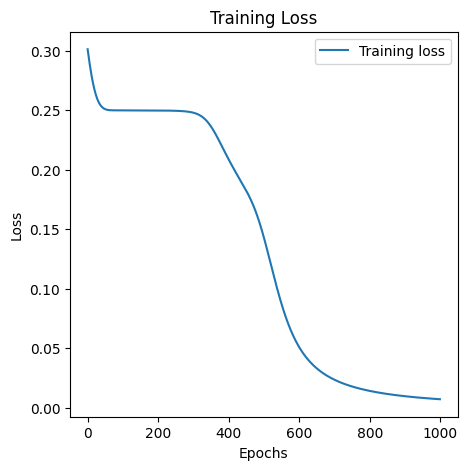

In [ ]:
history_loss = and_model.history

epochs = history_loss['epochs']
loss = history_loss['loss']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.plot(epochs, loss, label="Training loss")
ax.set_title("Training Loss")
ax.legend(loc='upper right')

## Load and visualize the data

In [ ]:
train_dataset = CIFAR10(root="./cifar", train=True, transform=ToTensor(), download=True)
test_dataset = CIFAR10(root="./cifar", train=False, transform=ToTensor())


  0%|          | 0.00/170M [00:00<?, ?B/s]
  0%|          | 65.5k/170M [00:00<04:47, 592kB/s]
  0%|          | 197k/170M [00:00<02:57, 960kB/s] 
  0%|          | 852k/170M [00:00<00:51, 3.29MB/s]
  2%|▏         | 3.28M/170M [00:00<00:15, 11.1MB/s]
  5%|▌         | 8.95M/170M [00:00<00:06, 26.2MB/s]
  9%|▊         | 14.8M/170M [00:00<00:04, 36.8MB/s]
 12%|█▏        | 20.2M/170M [00:00<00:03, 41.3MB/s]
 16%|█▌        | 26.7M/170M [00:00<00:03, 46.2MB/s]
 19%|█▉        | 33.2M/170M [00:00<00:02, 49.2MB/s]
 23%|██▎       | 39.6M/170M [00:01<00:02, 51.2MB/s]
 27%|██▋       | 45.9M/170M [00:01<00:02, 52.3MB/s]
 31%|███       | 52.3M/170M [00:01<00:02, 53.2MB/s]
 34%|███▍      | 58.7M/170M [00:01<00:02, 53.8MB/s]
 38%|███▊      | 65.1M/170M [00:01<00:01, 54.3MB/s]
 42%|████▏     | 71.7M/170M [00:01<00:01, 54.8MB/s]
 46%|████▌     | 78.1M/170M [00:01<00:01, 54.9MB/s]
 50%|████▉     | 84.5M/170M [00:01<00:01, 55.1MB/s]
 53%|█████▎    | 91.0M/170M [00:02<00:01, 55.3MB/s]
 57%|█████▋    | 97.5M/

In [ ]:
print(f'Training images: {len(train_dataset)}')
print(f'Testing images: {len(test_dataset)}')

Training images: 50000
Testing images: 10000


In [ ]:
train_dataset, val_dataset = random_split(train_dataset, lengths=[45000, 5000])

### Datasets & DataLoaders

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: **torch.utils.data.DataLoader** and **torch.utils.data.Dataset** that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

In [ ]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

Once we loaded the datasets, we can get a batch of images and display them. It is generally a good idea to visualize the images in order to see if additional preprocessing is needed.

tensor([8, 0, 7, 5, 4])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])


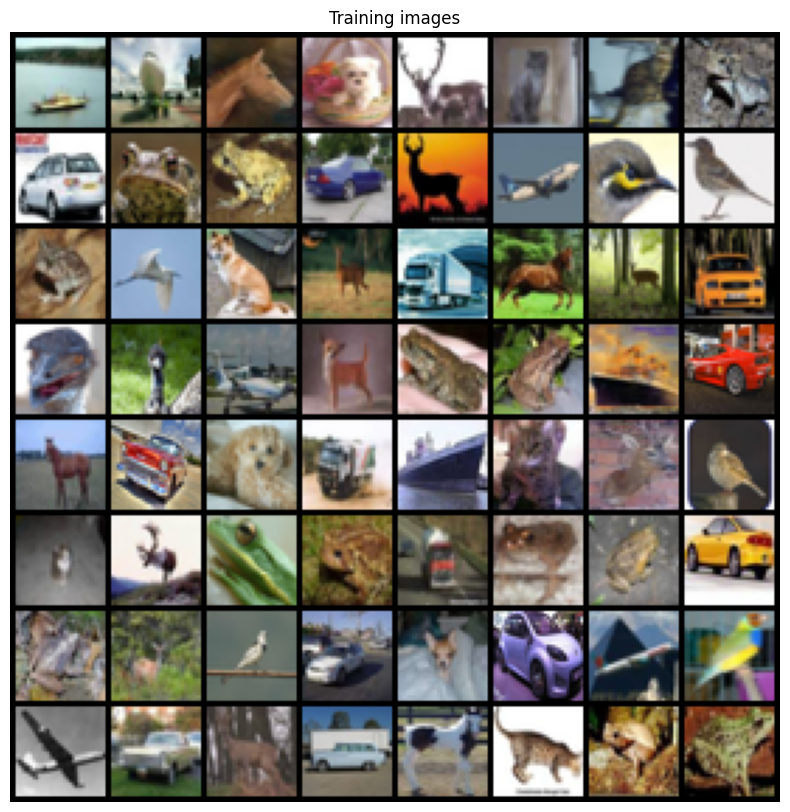

In [ ]:
images, labels = next(iter(train_loader))

one_hot = torch.nn.functional.one_hot(labels)

print(labels[:5])
print(one_hot[:5])

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], padding=2,normalize=True), (1, 2, 0)))
plt.show()

## Training the model

The MNISTModel class is used as the basis for training. We need to give it a model to operate on the data.

### Model definition

In [ ]:
class CifarCnnModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        """Initialize the CifarCnnModel class.

            Args:
                model (torch.nn.Module): The CNN model to be used for training and inference.
                learning_rate (float): The learning rate for the optimizer.
        """
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        # Initialize accuracy metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=10)
        self.val_acc = Accuracy(task="multiclass", num_classes=10)
        self.test_acc = Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        """Forward pass of the model.

            Args:
                x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28)

            Returns:
                torch.Tensor: Output tensor after passing through the model
        """
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """Perform a training step.

            Args:
                batch: A batch of training data containing features and labels.
                batch_idx (int): Index of the current batch in the epoch.

            Returns:
                torch.Tensor: Loss tensor to be optimized
        """
        features, true_labels = batch
        logits = self(features)
        loss = F.cross_entropy(logits, true_labels)

        # Calculate and log training accuracy
        preds = torch.argmax(logits, dim=1)
        self.train_acc(preds, true_labels)
        self.log("train_acc", self.train_acc, prog_bar=True)
        self.log("train_loss", loss)
        return loss  # this is passed to the optimizer for training

    def validation_step(self, batch, batch_idx):
        """Perform a validation step.

            Args:
                batch: A batch of validation data containing features and labels.
                batch_idx (int): Index of the current batch in the validation set.

            Returns:
                torch.Tensor: Validation loss tensor
        """
        features, true_labels = batch
        logits = self(features)
        loss = F.cross_entropy(logits, true_labels)

        # Calculate and log validation accuracy
        preds = torch.argmax(logits, dim=1)
        self.val_acc(preds, true_labels)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        """Perform a test step.

            Args:
                batch: A batch of test data containing features and labels.
                batch_idx (int): Index of the current batch in the test set.
        """
        features, true_labels = batch
        logits = self(features)

        # Calculate and log test accuracy
        preds = torch.argmax(logits, dim=1)
        self.test_acc(preds, true_labels)
        self.log("test_acc", self.test_acc)


    def configure_optimizers(self):
        """Configure the optimizer for training.

            Returns:
                torch.optim.Optimizer: Optimizer for training
        """
        optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        return optimizer

In [ ]:
class PyTorchCNN(torch.nn.Module):
    def __init__(self, num_classes):
        """Initialize the PyTorchCNN class.

        Args:
            num_classes (int): The number of output classes for the model.
        """
        super().__init__()

        # Define the CNN layers
        self.cnn_layers = torch.nn.Sequential(

            # First convolutional layer with batch normalization and ReLU activation
            torch.nn.Conv2d(3, 32, kernel_size=3),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),

            torch.nn.MaxPool2d(kernel_size=2),

            # Second convolutional layer with batch normalization and ReLU activation
            torch.nn.Conv2d(32, 64, kernel_size=3),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),

            # Third convolutional layer with batch normalization and ReLU activation
            torch.nn.Conv2d(64, 128, kernel_size=3),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )

        # Define the fully connected layers
        self.fc_layers = torch.nn.Sequential(

            # Hidden fully connected layer with batch normalization and ReLU activation
            torch.nn.Linear(512, 16),
            torch.nn.BatchNorm1d(16),
            torch.nn.ReLU(),

            # output layer
            torch.nn.Linear(16, num_classes)
        )

    def forward(self, x):
        """Forward pass of the model.

            Args:
                x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28)

            Returns:
                torch.Tensor: Output logits tensor of shape (batch_size, num_classes)
        """
        # Forward pass through the CNN layers
        x = self.cnn_layers(x)
        # print(x.shape)
        # Flatten the output of CNN layers to prepare for fully connected layers
        x = torch.flatten(x, start_dim=1)
        # print(x.shape)
        # Forward pass through the fully connected layers to get the logits
        logits = self.fc_layers(x)
        # print(logits.shape)
        return logits

### Training the CNN

In [ ]:
pytorch_cnn_model = PyTorchCNN(num_classes=10)
cifar_cnn_model = CifarCnnModel(model=pytorch_cnn_model, learning_rate=0.1)

trainer_cnn = L.Trainer(
    max_epochs=15,
    logger=CSVLogger(save_dir="logs/", name="cifar-cnn-model"),
)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer_cnn.fit(
        model=cifar_cnn_model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader,
    )

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | PyTorchCNN         | 102 K  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.408     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | PyTorchCNN         | 102 K  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccur

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


### Results and predictions

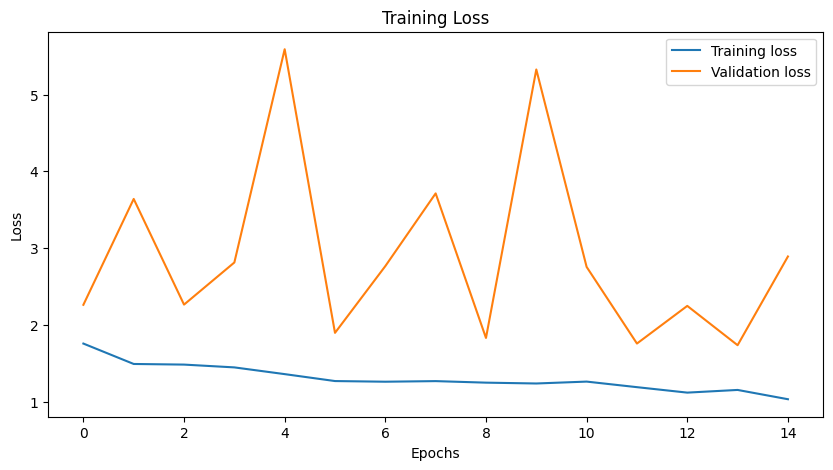

In [ ]:
# Read the metrics.csv file generated by the PyTorch Lightning logger
metrics = pd.read_csv(f"{trainer_cnn.logger.log_dir}/metrics.csv")
# Group the metrics by epoch and compute the mean loss for each epoch
df_epochs = metrics.groupby('epoch').mean()

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Loss')
# Plot the training loss over epochs
ax.plot(df_epochs['train_loss'], label="Training loss")
# Plot the validation loss over epochs
ax.plot(df_epochs['val_loss'], label="Validation loss")
# Set the title of the plot
ax.set_title("Training Loss")
# Add a legend to the plot
ax.legend(loc='upper right')

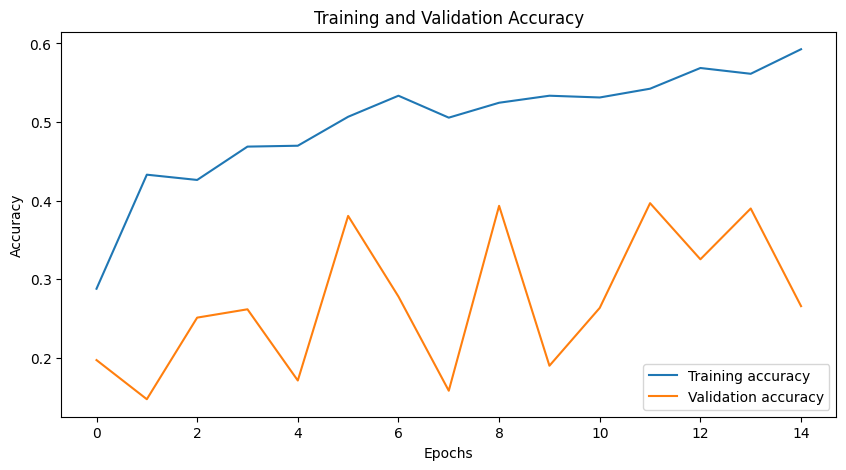

In [ ]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Accuracy')
# Plot the training accuracy over epochs
ax.plot(df_epochs['train_acc'], label="Training accuracy")
# Plot the validation accuracy over epochs
ax.plot(df_epochs['val_acc'], label="Validation accuracy")
# Set the title of the plot
ax.set_title("Training and Validation Accuracy")
# Add a legend to the plot
ax.legend(loc='lower right')
plt.show()

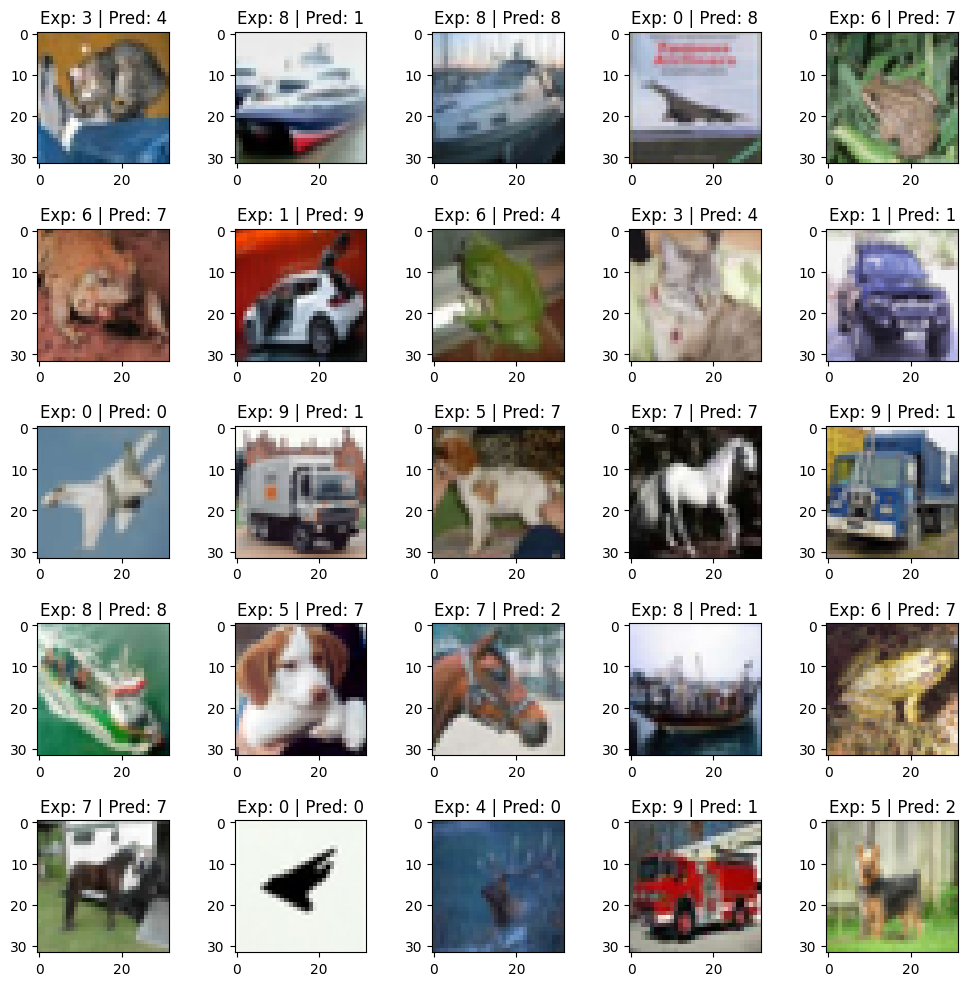

In [ ]:
# Create a 5x5 subplot figure
f, ax = plt.subplots(5, 5, figsize=(10, 10))
# Adjust the layout of the subplots to avoid overlapping
f.tight_layout(pad=1.)

# Iterate over the first 25 test images
for idx in range(25):
    # Calculate the row and column index for the subplot
    row = idx // 5
    col = idx % 5

    # Get the test data and label for the current image
    test_data, test_label = test_dataset[idx] # Assuming this is a (3, 32, 32) Tensor

    # Convert from (C, H, W) to (H, W, C) for matplotlib
    # Also convert from torch.Tensor to numpy.ndarray
    img_to_plot = test_data.numpy().transpose(1, 2, 0)
    # Plot the test image (removed cmap='gray')
    ax[row, col].imshow(img_to_plot)

    # Add a batch dimension (B) to (C, H, W) -> (B, C, H, W)
    # Shape becomes (1, 3, 32, 32)
    model_input = test_data.unsqueeze(0)

    # Forward pass of the model without gradient computation
    with torch.no_grad():
        # Set the model to evaluation mode
        mnist_cnn_model.eval()
        # Get the model prediction for the test data
        prediction = mnist_cnn_model(model_input) # Use the correctly shaped tensor

    # Set the title of the subplot with expected and predicted labels
    # Use torch.argmax since 'prediction' is a tensor
    ax[row, col].set_title(f'Exp: {test_label} | Pred: {torch.argmax(prediction)}')